In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [6]:
import camb

In [7]:
def model_rs(ombh2,omch2,nnu, z_star):
  #Calculation of theoretical values with CAMB for rs/Dm, ombh2, omch2+ombh2
  camb_params = camb.CAMBparams()
  camb_params.set_cosmology(ombh2=ombh2,omch2=omch2,nnu=nnu,num_massive_neutrinos=0,mnu=0,H0=70)
  camb_result = camb.get_background(camb_params)
  rs = camb_result.sound_horizon(z_star)

  return rs

model_rs(0.022,0.12,3,1089)

np.float64(145.06987059894234)

  0%|          | 0/15 [00:00<?, ?it/s]

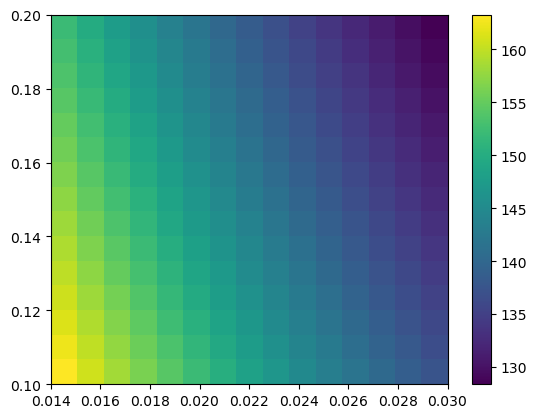

In [8]:
wb_limits=[0.014,0.03]
wbc_limits=[0.1,0.2]
Neff_limits=[3,3.1]

n_samples=15

grid=np.linspace(0,1,n_samples)
wb_grid=grid*(wb_limits[1]-wb_limits[0])+wb_limits[0]
wbc_grid=grid*(wbc_limits[1]-wbc_limits[0])+wbc_limits[0]
Neff_grid=grid*(Neff_limits[1]-Neff_limits[0])+Neff_limits[0]

wb_grid

n=0

#Calculation of the sound horizon for every point in the grid
rs=np.zeros(shape=(n_samples,n_samples,n_samples))
for i in tqdm(range(n_samples)):
  for j in range(n_samples):
    for k in range(n_samples):
      rs[i,j,k]=model_rs(wb_grid[i],wbc_grid[j]-wb_grid[i],Neff_grid[k],1089)

plt.imshow(rs[:,:,0],origin='lower',aspect='auto',extent=[wb_limits[0],wb_limits[1],wbc_limits[0],wbc_limits[1]] )
plt.colorbar()

In [9]:
wb_ref=0.02236
wbc_ref=0.1432
Neff_ref=3.04
rs_ref=model_rs(0.02236,0.1432-0.02236,3.04,1089)

In [10]:
def model_log_rs_analytica(theta, ombh2,ombch2,Neff):
  return (
    np.log10(rs_ref)
    + theta[0] * np.log10(ombh2 / wb_ref)
    + theta[1] * np.log10(ombch2 / wbc_ref)
    + theta[2] * np.log10(Neff / Neff_ref)
  )

In [11]:
ombh2,ombch2,Neff=np.meshgrid(wb_grid,wbc_grid-wb_grid,Neff_grid)
print(ombh2.shape,ombch2.shape,Neff.shape)
print(wb_grid.shape, rs.shape)

(15, 15, 15) (15, 15, 15) (15, 15, 15)
(15,) (15, 15, 15)


In [12]:
def func(theta, ombh2, ombch2, Neff, rs):
    return np.sum((model_log_rs_analytica(theta, ombh2, ombch2, Neff) - np.log10(rs)) ** 2)

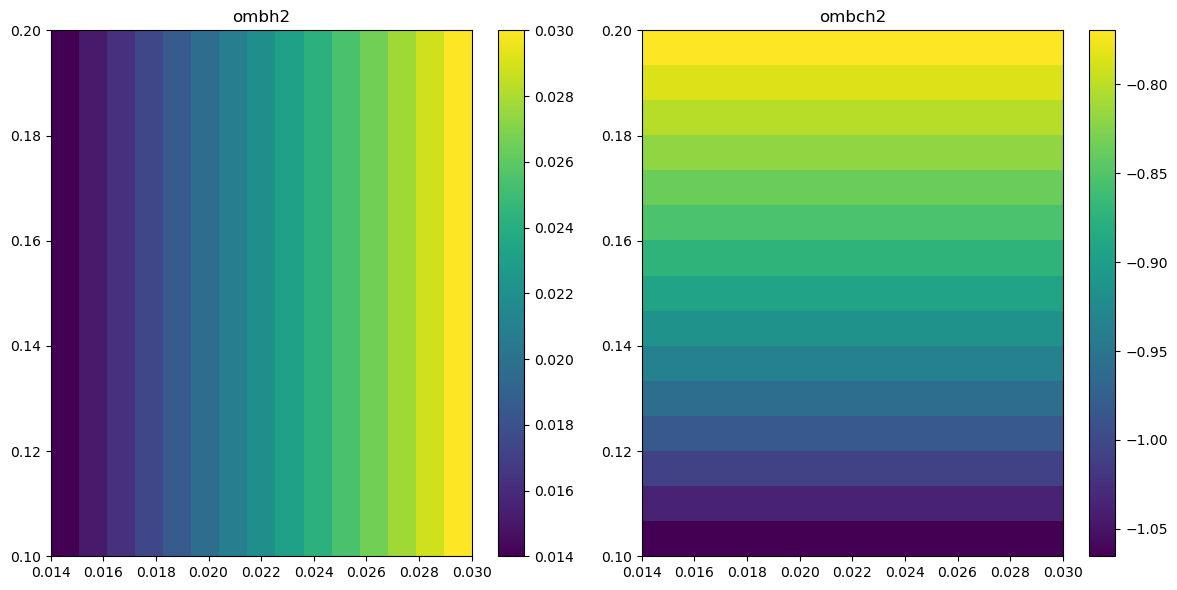

In [13]:
figure, ax = plt.subplots(1, 2, figsize=(12, 6))

im0 = ax[0].imshow(ombh2[:, :, 0], origin='lower', aspect='auto', extent=[wb_limits[0], wb_limits[1], wbc_limits[0], wbc_limits[1]])
figure.colorbar(im0, ax=ax[0])
ax[0].set_title("ombh2")

im1 = ax[1].imshow(np.log10(ombch2[:, :, 0]), origin='lower', aspect='auto', extent=[wb_limits[0], wb_limits[1], wbc_limits[0], wbc_limits[1]])
figure.colorbar(im1, ax=ax[1])
ax[1].set_title("ombch2")

figure.tight_layout()
plt.show()


[-0.21010943 -0.04447806 -0.69813414]
  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.3547845212661237
        x: [-2.101e-01 -4.448e-02 -6.981e-01]
      nit: 5
      jac: [-4.359e-07 -5.700e-07  6.333e-08]
 hess_inv: [[ 1.417e-02 -1.226e-03  1.262e-02]
            [-1.226e-03  1.326e-02  4.922e-02]
            [ 1.262e-02  4.922e-02  7.164e+00]]
     nfev: 32
     njev: 8


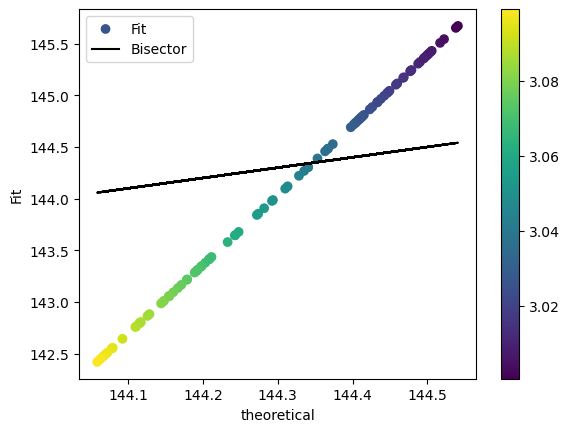

In [14]:
from scipy.optimize import minimize

func([-0.13,-0.23,-0.1],ombh2, ombch2,Neff,rs)

result = minimize(func, [-0.13, -0.23, -0.1], args=(ombh2, ombch2, Neff, rs))
print(result.x)
print(result)

Neff_random=np.random.uniform(Neff_limits[0],Neff_limits[1],100)
rs_random=np.array([model_rs(0.02236,0.1432-0.02236,Neff_random[i],1089) for i in range(100)])
rs_analytica=10**np.array([model_log_rs_analytica(result.x,wb_ref,wbc_ref,Neff_random[i]) for i in range(100)])

plt.scatter(rs_random,rs_analytica,label="Fit",c=Neff_random)
plt.colorbar()
plt.plot(rs_random,rs_random,label="Bisector", color="black")
plt.xlabel("theoretical")
plt.ylabel("Fit")
plt.legend()

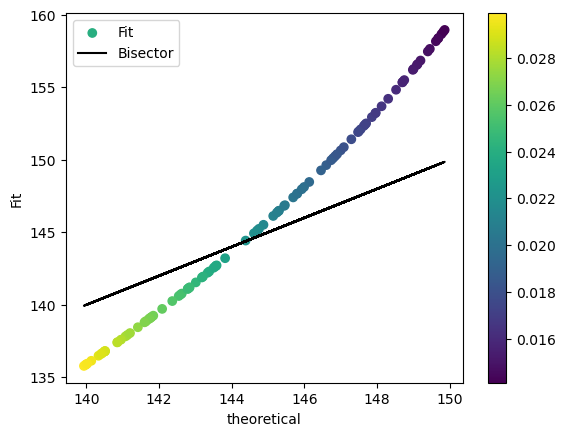

In [15]:
wb_random=np.random.uniform(wb_limits[0],wb_limits[1],100)
rs2_random=np.array([model_rs(wb_random[i],wbc_ref-wb_random[i],Neff_ref,1089) for i in range(100)])
rs2_analytica=10**np.array([model_log_rs_analytica(result.x,wb_random[i],wbc_ref,Neff_ref) for i in range(100)])

plt.scatter(rs2_random,rs2_analytica,label="Fit",c=wb_random)
plt.colorbar()
plt.plot(rs2_random,rs2_random,label="Bisector", color="black")
plt.xlabel("theoretical")
plt.ylabel("Fit")
plt.legend()